# Sampyo

1. classification model
2. 7class
3. 2.5% + 5%

## Import module

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
import random

Using TensorFlow backend.
/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cai/anaconda3/envs/MRCNN/l

## train data / test data

In [2]:
dataset_name = "./crop_dataset_water"

x_train = []
y_train = []
x_test = []
y_test = []

folder_list = os.listdir(dataset_name)
folder_list.sort()

In [3]:
folder_list

['FM_2.4_2.5%',
 'FM_2.4_5%',
 'FM_2.6_2.5%',
 'FM_2.6_5%',
 'FM_2.8_2.5%',
 'FM_2.8_5%',
 'FM_3.0_2.5%',
 'FM_3.0_5%',
 'FM_3.2_2.5%',
 'FM_3.2_5%',
 'FM_3.4_2.5%',
 'FM_3.4_5%',
 'FM_3.61_2.5%',
 'FM_3.61_5%']

In [4]:
def CLAHE(img, limit = 2.0, grid = 8):
    clahe = cv2.createCLAHE(clipLimit = limit, tileGridSize = (grid, grid))
    return clahe.apply(img)

for one_folder in folder_list:
    splited_one_folder =  one_folder.split("_")
    eveloped_one_folder = splited_one_folder[0]+"_"+splited_one_folder[1]
    # eveloped_one_folder : FM_classnum
    print(one_folder)
    
    join_folder_path = os.path.join(dataset_name, one_folder)
    # dataset folder path
    data_list = os.listdir(join_folder_path)
    # data list in folder
    
    ## train / test = 8:2
    test_list = random.sample(data_list, int(len(data_list) * 0.2))

    for one_data in data_list:
        
        join_data_path = os.path.join(join_folder_path, one_data)
        # each data path
        
        ### imread / resize / normalize
        img = cv2.imread(join_data_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (512,512))
        img = CLAHE(img) # apply equalization
        img = np.reshape(img, (512,512,1)) # one channel

        # train
        if not one_data in test_list:
            # if data is not in test_list which is sampled before, add data in x_train, and class in y_train
            x_train.append(img)
            y_train.append(eveloped_one_folder)
            
        elif one_data in test_list:
            x_test.append(img)
            y_test.append(eveloped_one_folder)

            
tmp = [[x,y] for x,y in zip(x_train, y_train)]
random.shuffle(tmp)

x_train = [n[0] for n in tmp]
y_train = [n[1] for n in tmp]
            
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)  
y_test = np.array(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

FM_2.4_2.5%
FM_2.4_5%
FM_2.6_2.5%
FM_2.6_5%
FM_2.8_2.5%
FM_2.8_5%
FM_3.0_2.5%
FM_3.0_5%
FM_3.2_2.5%
FM_3.2_5%
FM_3.4_2.5%
FM_3.4_5%
FM_3.61_2.5%
FM_3.61_5%
(9348, 512, 512, 1)
(9348,)
(2333, 512, 512, 1)
(2333,)


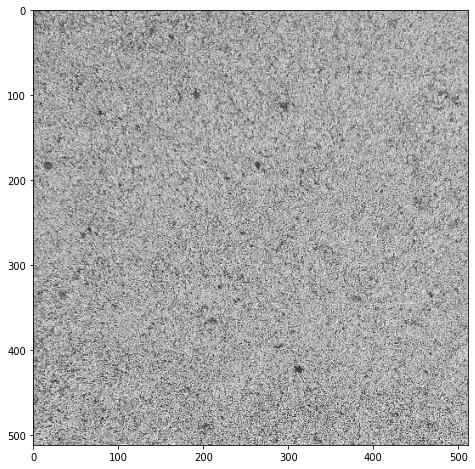

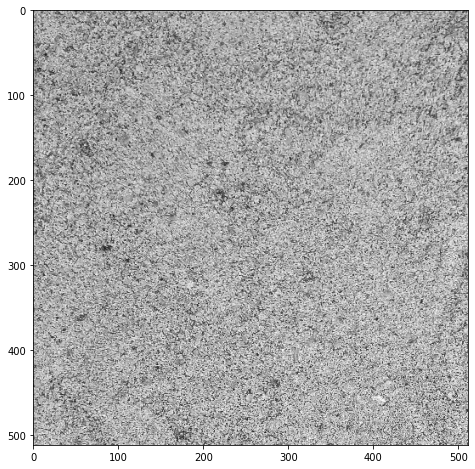

In [5]:
plt.figure(figsize=(8,8))
plt.imshow(x_train[1].reshape(512,512), cmap="gray")

plt.figure(figsize=(8,8))
plt.imshow(x_test[0].reshape(512,512), cmap="gray")

## Y data onehot encoding

* ex1) 2 -> [1,0,0,0,0,0]
* ex2) 7 -> [0,0,0,0,0,1]

In [6]:
from sklearn.preprocessing import OneHotEncoder

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

enc = OneHotEncoder()
enc.fit(y_train)

y_train_onehot = enc.transform(y_train).toarray()
y_test_onehot = enc.transform(y_test).toarray()

print(y_test_onehot)
print(y_test)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[['FM_2.4']
 ['FM_2.4']
 ['FM_2.4']
 ...
 ['FM_3.61']
 ['FM_3.61']
 ['FM_3.61']]


## Import keras module

In [10]:
import keras

from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout, LeakyReLU
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization

from keras.utils import multi_gpu_model

from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

## Deep Learning Model

In [11]:
inputs = Input((512, 512, 1))

# Layer 1
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(inputs)
x = LeakyReLU(alpha = 0.1)(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha = 0.1)(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 2
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha = 0.1)(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha = 0.1)(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 3
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha = 0.1)(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha = 0.1)(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 4
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha = 0.1)(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha = 0.1)(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha = 0.1)(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 5
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha = 0.1)(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha = 0.1)(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha = 0.1)(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 6
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha = 0.1)(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha = 0.1)(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha = 0.1)(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 7
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha = 0.1)(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha = 0.1)(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha = 0.1)(x)
x = MaxPooling2D(pool_size = 2, strides = 2, name = 'last_pool')(x)

x = Flatten()(x)
x = Dense(128,kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha = 0.1)(x)
x = Dense(64,kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha = 0.1)(x)
outputs = Dense(7, activation = 'softmax',kernel_initializer="glorot_normal")(x)

model = Model(inputs=[inputs], outputs=[outputs])

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 128)     1280      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512, 512, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512, 512, 128)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 128)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 128)     147584    
__________

In [13]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train_onehot,y_val_onehot = train_test_split(x_train,y_train_onehot, test_size = 0.1, shuffle = True, random_state = 42)

In [14]:
#early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', verbose = 0, patience = 20, mode = 'auto')

#checkpoint
checkpoint_path = './minyoung_checkpoint/all_CLAHE__{epoch:04d}.ckpt'
cp_dir = os.path.dirname(checkpoint_path)
checkpoint_50epoch = keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only = True, verbose = 1, period = 50)

## Learning

In [15]:
parallel_model = multi_gpu_model(model,gpus=2)

# callback
# early_stopping = EarlyStopping(monitor='val_loss',patience = 30)

# optimizer
adam = keras.optimizers.Adam(lr=0.000001)
parallel_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# fit model
hist = parallel_model.fit(x_train, y_train_onehot,\
                          epochs=2000, batch_size=4,\
                          validation_data=(x_val, y_val_onehot),\
                         callbacks = [checkpoint_50epoch])

# plot loss & val_loss
plt.figure(figsize=(20,12))
plt.plot(hist.history['loss'],'b',label='loss')
plt.plot(hist.history['val_loss'],'r',label='val_loss')
#plt.xticks(np.arange(0,50,1))
plt.legend(loc="upper right");

Instructions for updating:
Use tf.cast instead.
Train on 8413 samples, validate on 935 samples
Epoch 1/2000
8413/8413 [==============================] - 241s 29ms/step - loss: 1.9448 - acc: 0.1539 - val_loss: 1.9426 - val_acc: 0.1551
Epoch 2/2000
8413/8413 [==============================] - 237s 28ms/step - loss: 1.9420 - acc: 0.1549 - val_loss: 1.9371 - val_acc: 0.1754
Epoch 3/2000
8413/8413 [==============================] - 237s 28ms/step - loss: 1.9291 - acc: 0.1779 - val_loss: 1.9259 - val_acc: 0.2107
Epoch 4/2000
8413/8413 [==============================] - 236s 28ms/step - loss: 1.8971 - acc: 0.2212 - val_loss: 1.8716 - val_acc: 0.1979
Epoch 5/2000
8413/8413 [==============================] - 236s 28ms/step - loss: 1.8682 - acc: 0.2231 - val_loss: 1.8450 - val_acc: 0.2107
Epoch 6/2000
8413/8413 [==============================] - 236s 28ms/step - loss: 1.8406 - acc: 0.2365 - val_loss: 1.8187 - val_acc: 0.2353
Epoch 7/2000
8413/8413 [==============================] - 236s 28ms/ste

8413/8413 [==============================] - 236s 28ms/step - loss: 1.0019 - acc: 0.5886 - val_loss: 0.9495 - val_acc: 0.6299
Epoch 57/2000
8413/8413 [==============================] - 236s 28ms/step - loss: 0.9836 - acc: 0.6012 - val_loss: 0.9350 - val_acc: 0.6374
Epoch 58/2000
8413/8413 [==============================] - 237s 28ms/step - loss: 0.9708 - acc: 0.6049 - val_loss: 1.1109 - val_acc: 0.5219
Epoch 59/2000
8413/8413 [==============================] - 237s 28ms/step - loss: 0.9652 - acc: 0.6062 - val_loss: 0.9523 - val_acc: 0.6289
Epoch 60/2000
8413/8413 [==============================] - 236s 28ms/step - loss: 0.9680 - acc: 0.6074 - val_loss: 1.0201 - val_acc: 0.5979
Epoch 61/2000
8413/8413 [==============================] - 237s 28ms/step - loss: 0.9550 - acc: 0.6097 - val_loss: 1.1023 - val_acc: 0.5166
Epoch 62/2000
8413/8413 [==============================] - 236s 28ms/step - loss: 0.9610 - acc: 0.6056 - val_loss: 0.9840 - val_acc: 0.6000
Epoch 63/2000
8413/8413 [=========

8413/8413 [==============================] - 237s 28ms/step - loss: 0.7147 - acc: 0.7210 - val_loss: 0.7637 - val_acc: 0.6984
Epoch 114/2000
8413/8413 [==============================] - 237s 28ms/step - loss: 0.7156 - acc: 0.7135 - val_loss: 0.7521 - val_acc: 0.6973
Epoch 115/2000
8413/8413 [==============================] - 237s 28ms/step - loss: 0.7178 - acc: 0.7156 - val_loss: 0.9285 - val_acc: 0.6075
Epoch 116/2000
8413/8413 [==============================] - 237s 28ms/step - loss: 0.7146 - acc: 0.7146 - val_loss: 0.8218 - val_acc: 0.6620
Epoch 117/2000
8413/8413 [==============================] - 237s 28ms/step - loss: 0.7032 - acc: 0.7177 - val_loss: 0.7910 - val_acc: 0.6888
Epoch 118/2000
8413/8413 [==============================] - 237s 28ms/step - loss: 0.6948 - acc: 0.7230 - val_loss: 0.8358 - val_acc: 0.6599
Epoch 119/2000
8413/8413 [==============================] - 237s 28ms/step - loss: 0.6991 - acc: 0.7207 - val_loss: 0.8011 - val_acc: 0.6813
Epoch 120/2000
8413/8413 [==

8413/8413 [==============================] - 237s 28ms/step - loss: 0.4680 - acc: 0.8224 - val_loss: 0.6334 - val_acc: 0.7583
Epoch 171/2000
8413/8413 [==============================] - 237s 28ms/step - loss: 0.4715 - acc: 0.8249 - val_loss: 0.5987 - val_acc: 0.7668
Epoch 172/2000
8413/8413 [==============================] - 236s 28ms/step - loss: 0.4619 - acc: 0.8274 - val_loss: 0.5501 - val_acc: 0.7829
Epoch 173/2000
8413/8413 [==============================] - 237s 28ms/step - loss: 0.4688 - acc: 0.8197 - val_loss: 0.6053 - val_acc: 0.7636
Epoch 174/2000
8413/8413 [==============================] - 237s 28ms/step - loss: 0.4568 - acc: 0.8267 - val_loss: 0.5593 - val_acc: 0.7968
Epoch 175/2000
8413/8413 [==============================] - 237s 28ms/step - loss: 0.4589 - acc: 0.8249 - val_loss: 0.5545 - val_acc: 0.7893
Epoch 176/2000
8413/8413 [==============================] - 237s 28ms/step - loss: 0.4601 - acc: 0.8255 - val_loss: 0.6006 - val_acc: 0.7572
Epoch 177/2000
8413/8413 [==

KeyboardInterrupt: 

In [16]:
parallel_model.load_weights('./minyoung_checkpoint/all_CLAHE__0027.ckpt')

In [26]:
#early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', verbose = 0, patience = 20, mode = 'auto')

#checkpoint
checkpoint_path = './minyoung_checkpoint/all_CLAHE__{epoch:04d}.ckpt'
cp_dir = os.path.dirname(checkpoint_path)
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only = True,save_best_only=True, verbose = 1, period = 1)

# fit model
hist = parallel_model.fit(x_train, y_train_onehot,\
                          epochs=200, batch_size=4,\
                          validation_data=(x_val, y_val_onehot),\
                         callbacks = [checkpoint,early_stopping])

# plot loss & val_loss
plt.figure(figsize=(20,12))
plt.plot(hist.history['loss'],'b',label='loss')
plt.plot(hist.history['val_loss'],'r',label='val_loss')
#plt.xticks(np.arange(0,50,1))
plt.legend(loc="upper right");

Train on 8413 samples, validate on 935 samples
Epoch 1/200
8412/8413 [============================>.] - ETA: 0s - loss: 0.2805 - acc: 0.8984
Epoch 00001: val_loss improved from inf to 0.47233, saving model to ./minyoung_checkpoint/all_CLAHE__0001.ckpt
8413/8413 [==============================] - 237s 28ms/step - loss: 0.2805 - acc: 0.8984 - val_loss: 0.4723 - val_acc: 0.8289
Epoch 2/200
8412/8413 [============================>.] - ETA: 0s - loss: 0.2685 - acc: 0.9069
Epoch 00002: val_loss improved from 0.47233 to 0.45064, saving model to ./minyoung_checkpoint/all_CLAHE__0002.ckpt
8413/8413 [==============================] - 238s 28ms/step - loss: 0.2685 - acc: 0.9069 - val_loss: 0.4506 - val_acc: 0.8406
Epoch 3/200
8412/8413 [============================>.] - ETA: 0s - loss: 0.2651 - acc: 0.9044
Epoch 00003: val_loss did not improve
8413/8413 [==============================] - 237s 28ms/step - loss: 0.2650 - acc: 0.9044 - val_loss: 0.4709 - val_acc: 0.8246
Epoch 4/200
8412/8413 [======

Epoch 31/200
8412/8413 [============================>.] - ETA: 0s - loss: 0.2038 - acc: 0.9268
Epoch 00031: val_loss did not improve
8413/8413 [==============================] - 238s 28ms/step - loss: 0.2037 - acc: 0.9268 - val_loss: 0.4719 - val_acc: 0.8396
Epoch 32/200
8412/8413 [============================>.] - ETA: 0s - loss: 0.1952 - acc: 0.9294
Epoch 00032: val_loss did not improve
8413/8413 [==============================] - 237s 28ms/step - loss: 0.1952 - acc: 0.9294 - val_loss: 0.4335 - val_acc: 0.8428
Epoch 33/200
8412/8413 [============================>.] - ETA: 0s - loss: 0.1929 - acc: 0.9321
Epoch 00033: val_loss did not improve
8413/8413 [==============================] - 237s 28ms/step - loss: 0.1929 - acc: 0.9321 - val_loss: 0.5588 - val_acc: 0.8139
Epoch 34/200
8412/8413 [============================>.] - ETA: 0s - loss: 0.1986 - acc: 0.9258
Epoch 00034: val_loss did not improve
8413/8413 [==============================] - 237s 28ms/step - loss: 0.1986 - acc: 0.9258 -

KeyboardInterrupt: 

In [27]:
parallel_model.load_weights('./minyoung_checkpoint/all_CLAHE__0027.ckpt')

## Predict

In [28]:
pred_y = parallel_model.predict(x_test)


In [29]:
y_test_onehot

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [30]:
pred_y = np.argmax(pred_y,axis=1 )
real_y = np.argmax(y_test_onehot,axis=1)

print(pred_y)
print(real_y)

[0 0 0 ... 6 6 6]
[0 0 0 ... 6 6 6]


In [31]:
corr_num1 = 0
corr_num2 = 0
for i in range(real_y.shape[0]):
    if pred_y[i] == real_y[i]:
        corr_num1 += 1
        
    if abs(int(pred_y[i]) - int(real_y[i])) <= 1:
        corr_num2 += 1
        
print(corr_num1 / real_y.shape[0] * 100, "%")
print(corr_num2 / real_y.shape[0] * 100, "%")

87.1410201457351 %
95.58508358336906 %


## Confusion Matrix

In [32]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(pred_y, real_y)

['2.4', '2.6', '2.8', '3.0', '3.2', '3.4', '3.61']


<AxesSubplot:>

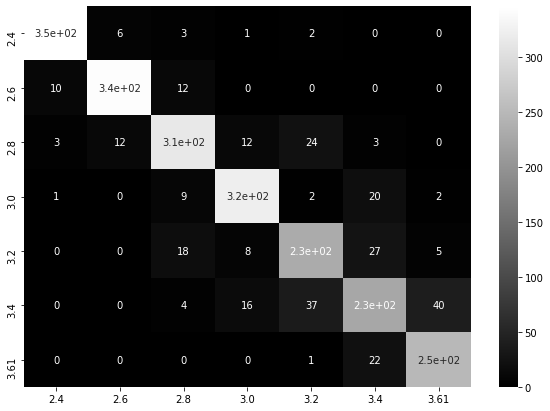

In [33]:
import seaborn as sn
import pandas as pd


cm_list = []
for one_folder in folder_list:
    splited_folder = one_folder.split("_")
    cm_list.append(splited_folder[1])
    cm_list = set(cm_list)
    cm_list = list(cm_list)
    cm_list.sort()
print(cm_list)
df_cm = pd.DataFrame(conf_mat, index = [i for i in cm_list],
                  columns = [i for i in cm_list])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="gray")

<AxesSubplot:>

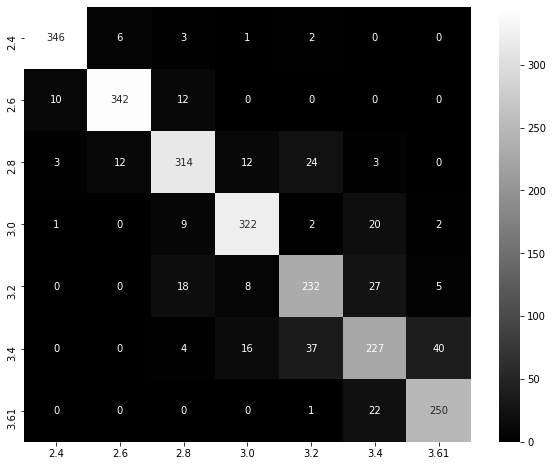

In [34]:
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True, cmap="gray", fmt="g")

In [35]:
model.save("all_CLAHE")